In [36]:
import warnings
warnings.filterwarnings("ignore")

from fbprophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from itertools import product
from sklearn.metrics import r2_score

import pandas as pd
pd.options.display.max_columns = 999
import numpy as np

from sklearn.metrics import mean_squared_error
#RMSE = mean_squared_error(y, y_pred)**0.5

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
%matplotlib inline
import matplotlib.pyplot as plt

In [33]:
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [34]:
def tsplot(df, lags=None, figsize=(12, 7), style='bmh'):
   
    if not isinstance(df, pd.Series):
        y = df['price']
        y.index = df.Date
    else:
         y = df
            
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

## Подготовка данных

18320

In [69]:
df_price = pd.read_csv('data/player_price.csv')
df_stats = pd.read_csv('data/player_stats.csv')
sample_subm = pd.read_csv('data/kaggle_sample_submission.csv')

sample_subm["player_id"] = sample_subm["id"].apply(lambda x: int(x.split("_")[0]))
sample_subm["Date"] = sample_subm["id"].apply(lambda x: np.datetime64(x.split("_")[1]))

#player_id=df_price.groupby(['player_id'])['xbox_price'].count()
player_id=sample_subm.groupby(['player_id'])['price'].count()

#df_price=df_price[df_price.player_id<=18320]
df_price['Date'] = pd.to_datetime(df_price['timestamp'], unit='ms')
df_price.drop(['timestamp'], axis=1, inplace=True)
df_price.drop(['ps_price'],axis = 1, inplace=True)
df_price.rename(columns={'xbox_price':'price'}, inplace = True)

df_merge=df_stats[["player_id"]].merge(df_price, on=['player_id'], how='inner')

df_merge.shape

(980252, 4)

In [70]:
df_new_data=df_merge[df_merge.Date>='2017-04-22']
df_new_data.head()

,player_id,price,player_name,Date
211,1,4166220,Pelé,2017-04-22
212,1,4016643,Pelé,2017-04-23
213,1,3849000,Pelé,2017-04-24
214,1,3823042,Pelé,2017-04-25
215,1,3762972,Pelé,2017-04-26


In [71]:
df_new_data_player=df_new_data[df_new_data.player_id==1]
print(df_new_data_player.shape)
df_new_data_player.tail(7)

(62, 4)


,player_id,price,player_name,Date
266,1,3212762,Pelé,2017-06-16
267,1,3312852,Pelé,2017-06-17
268,1,3227893,Pelé,2017-06-18
269,1,3142655,Pelé,2017-06-19
270,1,3135387,Pelé,2017-06-20
271,1,3248943,Pelé,2017-06-21
272,1,3137143,Pelé,2017-06-22


In [72]:
df_new_data_player_train=df_new_data_player[:-7]
df_new_data_player_train.shape

(55, 4)

In [26]:
df_new_data_player_valid=df_new_data_player[-7:]
df_new_data_player_valid.shape

(7, 4)

In [55]:
player1_id = (df_new_data.player_id ==  2)
player1_ts = df_new_data[player1_id].price
player1_ts.index = df_new_data[player1_id].Date
player1_ts.tail(10)

Date
2017-06-13    789865
2017-06-14    787050
2017-06-15    779230
2017-06-16    784590
2017-06-17    772174
2017-06-18    761528
2017-06-19    757681
2017-06-20    747924
2017-06-21    741715
2017-06-22    742514
Name: price, dtype: int64

In [10]:
(player1_ts.index.min(), player1_ts.index.max())

(Timestamp('2017-03-22 00:00:00'), Timestamp('2017-06-22 00:00:00'))

In [11]:
print(len(player1_ts), len(player1_ts[player1_ts==0]))
#player1_ts = player1_ts.replace(to_replace=0, method='bfill')
#print(len(player1_ts), len(player1_ts[player1_ts==0]))

93 0


### Исходный график временного рядя с ценами

Критерий Дики-Фуллера: p=0.351301


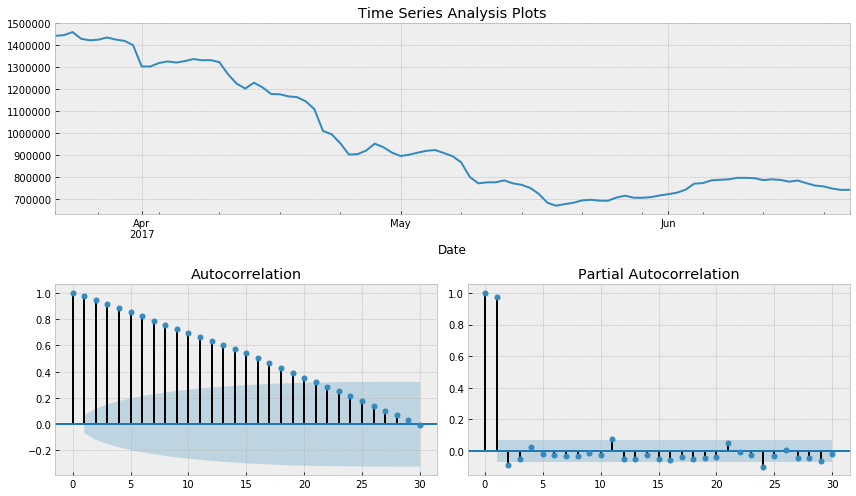

In [56]:
tsplot(player1_ts,lags = 30)

### STL-декомпозиция 

In [57]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


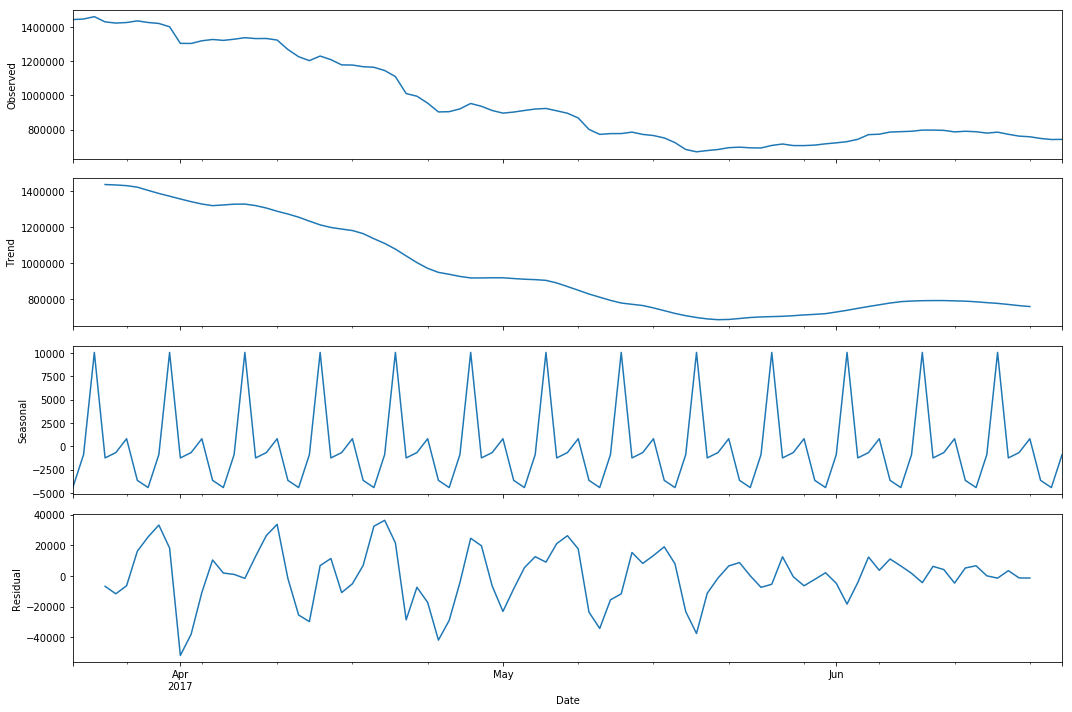

In [58]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(player1_ts).plot()
pylab.show()

### Проверка ряда на стационарность

In [59]:
#print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['y'])[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(player1_ts)[1])

Критерий Дики-Фуллера: p=0.351301


### Стабилизация дисперсии

In [60]:
modified_ts, lmbda = stats.boxcox(player1_ts)
lmbda

-3.9546451728440193

In [61]:
lmbda = 0
modified_ts = stats.boxcox(player1_ts,lmbda = 0)

Критерий Дики-Фуллера: p=0.497636
Ряд после преобразования Бокса-Кокса c пареметром lmbda: 0.000000


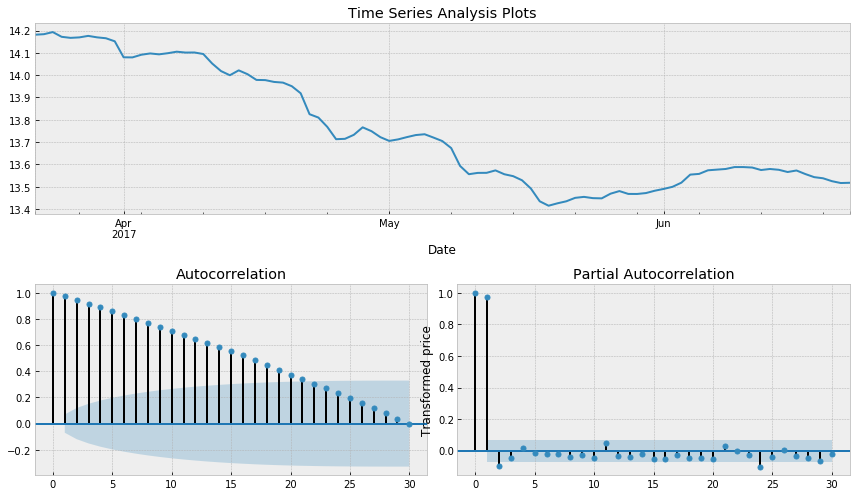

In [63]:
player1_ts_box=pd.Series(modified_ts)
player1_ts_box.index = player1_ts.index[:]

tsplot(player1_ts_box,lags = 30)
plt.ylabel(u'Transformed price')
print("Ряд после преобразования Бокса-Кокса c пареметром lmbda: %1f" % lmbda)
#plt.show()

### Избавляемся от тренда и сезонности

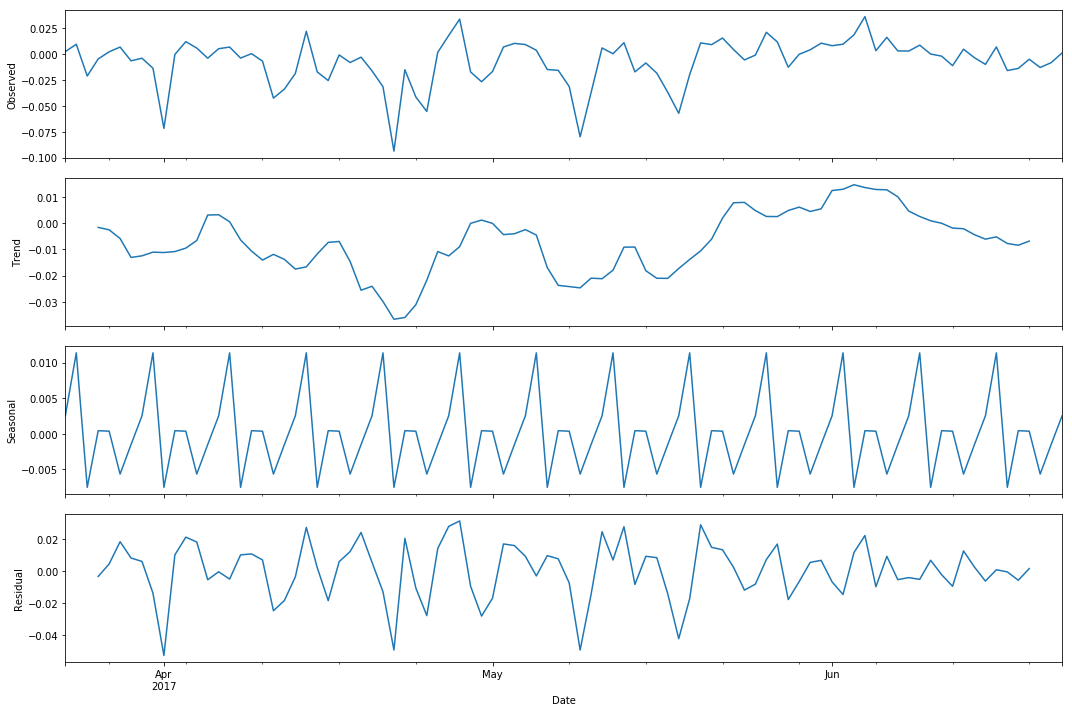

In [64]:
player1_ts_diff = player1_ts_box - player1_ts_box.shift(1)
player1_ts_diff = player1_ts_diff[1:]
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(player1_ts_diff).plot()
pylab.show()

Критерий Дики-Фуллера: p=0.000000


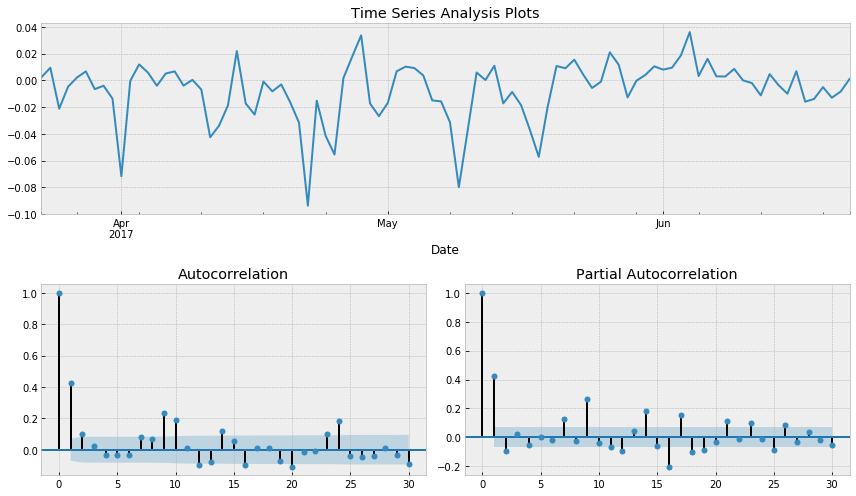

In [65]:
tsplot(player1_ts_diff,30)

In [66]:
ps = range(0, 8)
d=1
qs = range(0, 8)
Ps = range(0, 1)
D=0
Qs = range(0, 1)


from itertools import product

parameters = product(ps, qs)#, Ps, Qs)
parameters_list = list(parameters)
print("Количество параметров: {}".format(len(parameters_list)))

Количество параметров: 64


### подбор параметров

In [67]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        #model=sm.tsa.statespace.SARIMAX(player1_ts_box, order=(param[0], d, param[1]), 
        #                                seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        model=sm.tsa.statespace.SARIMAX(player1_ts_box, order=(param[0], d, param[1])).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0)
wrong parameters: (1, 4)
wrong parameters: (2, 1)
wrong parameters: (2, 3)
wrong parameters: (2, 4)
wrong parameters: (3, 2)
wrong parameters: (3, 3)
wrong parameters: (3, 4)
wrong parameters: (4, 2)
wrong parameters: (4, 3)
wrong parameters: (4, 4)
wrong parameters: (4, 6)
wrong parameters: (5, 2)
wrong parameters: (5, 3)
wrong parameters: (5, 4)
wrong parameters: (5, 6)
wrong parameters: (6, 3)
wrong parameters: (6, 4)
wrong parameters: (6, 5)
wrong parameters: (6, 6)
wrong parameters: (7, 3)
wrong parameters: (7, 4)
wrong parameters: (7, 5)
wrong parameters: (7, 6)
Wall time: 25.7 s


In [68]:
best_param

(1, 0)

In [69]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

   parameters         aic
7      (1, 0) -452.804467
8      (1, 1) -451.118200
9      (1, 2) -451.098686
14     (2, 0) -451.048598
0      (0, 1) -450.876067


In [70]:
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   93
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 228.402
Date:                Fri, 07 Jul 2017   AIC                           -452.804
Time:                        08:51:31   BIC                           -447.739
Sample:                    03-22-2017   HQIC                          -450.759
                         - 06-22-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4775      0.075      6.339      0.000       0.330       0.625
sigma2         0.0004   4.27e-05      9.531      0.000       0.000       0.000
Ljung-Box (Q):                       42.84   Jarque-

In [71]:
print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[1:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[1:])[1])

Критерий Стьюдента: p=0.073603
Критерий Дики-Фуллера: p=0.000000


## остатки

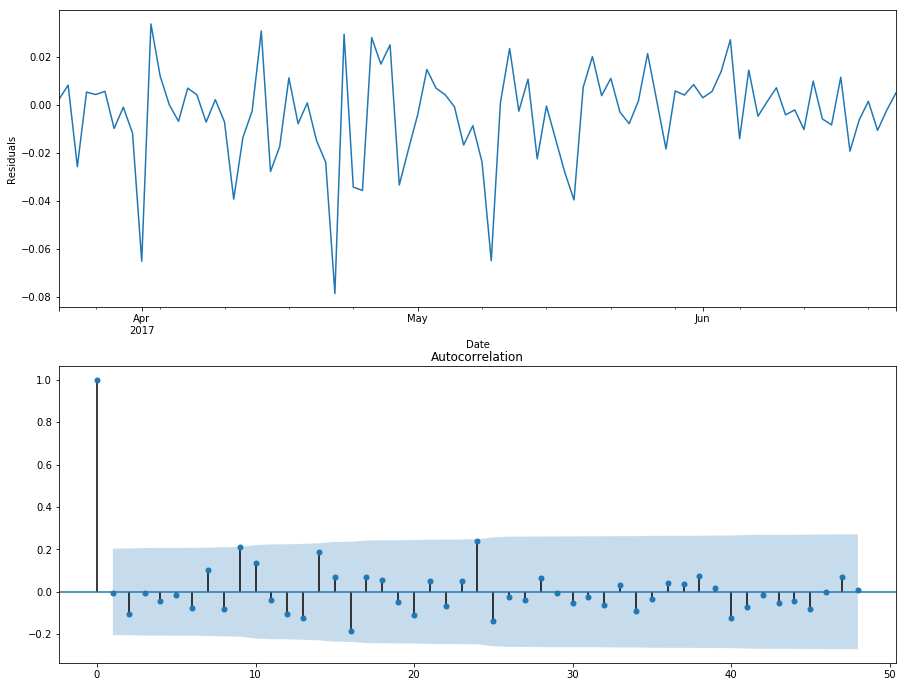

In [72]:
plt.figure(figsize(15,12))
plt.subplot(211)
best_model.resid[1:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[1:].values.squeeze(), lags=48, ax=ax)
plt.show()

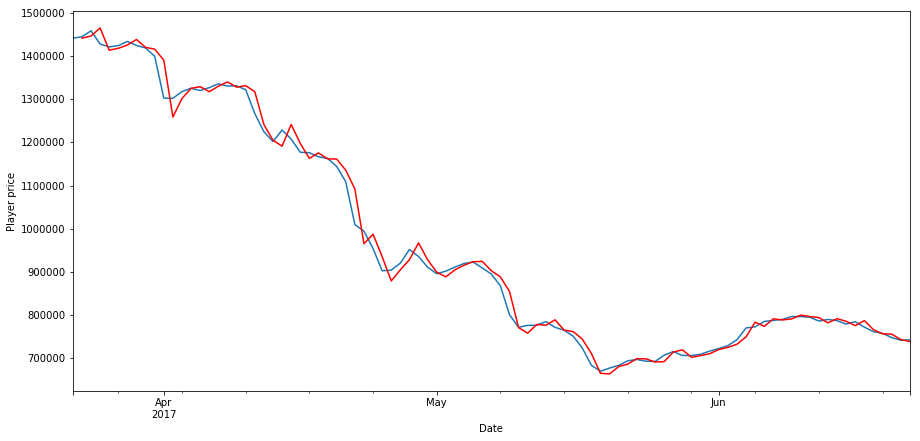

In [73]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

plt.figure(figsize(15,7))
player1_ts.plot()
#best_model.fittedvalues[1:].plot(color='r')
invboxcox(best_model.fittedvalues[1:], lmbda).plot(color = 'r')
plt.ylabel('Player price')
pylab.show()

** коэффициент детерминации **

In [74]:
r2_score(invboxcox(best_model.fittedvalues[1:],lmbda), player1_ts[1:])

0.9934795384817301

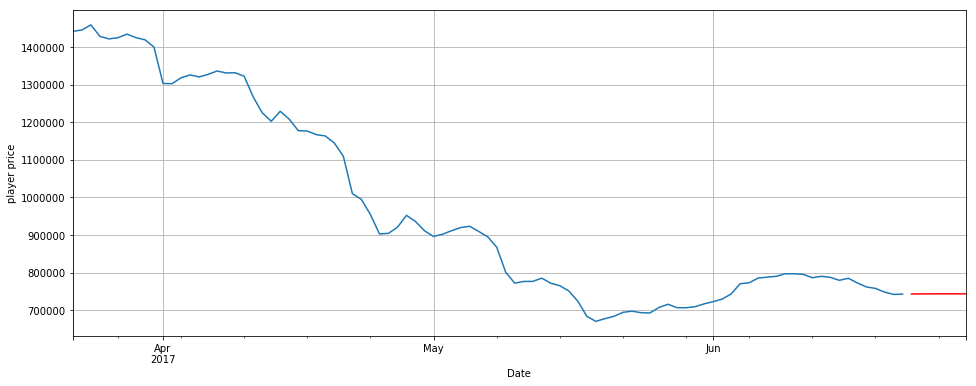

In [75]:
plt.figure(figsize(16,6))
player1_ts.plot()
predict=invboxcox(best_model.predict(start=93, end=99),lmbda)
#predict=best_model.predict(start=93, end=99)
#predict=predict*100
invboxcox(best_model.predict(start=93, end=99),lmbda).plot(color='r')
plt.ylabel('player price')
plt.grid()
pylab.show()

In [76]:
predict#.values

2017-06-23    742895.852908
2017-06-24    743078.269761
2017-06-25    743165.395732
2017-06-26    743207.004912
2017-06-27    743226.875514
2017-06-28    743236.364581
2017-06-29    743240.895971
Freq: D, dtype: float64

In [101]:
mean_squared_error(predict[-7:], player1_ts[-7:])**0.5

82875.567473094838

In [48]:
player1_ts.tail(7)

Date
2017-06-16    3212762
2017-06-17    3312852
2017-06-18    3227893
2017-06-19    3142655
2017-06-20    3135387
2017-06-21    3248943
2017-06-22    3137143
Name: price, dtype: int64

In [611]:
plid=2

In [612]:
pp=pd.DataFrame(columns=['id','price'])

In [617]:
pp['id']=str(plid)+'_'+predict.index.astype(str)

In [618]:
pp.price=predict.values
pp.price=pp.price.astype(int)
pp.to_csv('prediction.csv',sep=',',header=True,index=False)

---------------

In [192]:
df_price = pd.read_csv('data/player_price.csv')
df_stats = pd.read_csv('data/player_stats.csv')
sample_subm = pd.read_csv('data/kaggle_sample_submission.csv')

sample_subm["player_id"] = sample_subm["id"].apply(lambda x: int(x.split("_")[0]))
sample_subm["Date"] = sample_subm["id"].apply(lambda x: np.datetime64(x.split("_")[1]))

#player_id=df_price.groupby(['player_id'])['xbox_price'].count()
player_id=sample_subm.groupby(['player_id'])['price'].count()

#df_price=df_price[df_price.player_id<=18320]
df_price['Date'] = pd.to_datetime(df_price['timestamp'], unit='ms')
df_price.drop(['timestamp'], axis=1, inplace=True)
df_price.drop(['ps_price'],axis = 1, inplace=True)
df_price.rename(columns={'xbox_price':'price'}, inplace = True)

df_merge=df_stats[["player_id"]].merge(df_price, on=['player_id'], how='inner')

df_merge.shape

(980252, 4)

In [193]:
df_new_data=df_merge[df_merge.Date>='2017-03-22']
print(df_new_data.shape)
df_new_data.head()

(398770, 4)


,player_id,price,player_name,Date
180,1,5245704,Pelé,2017-03-22
181,1,5224824,Pelé,2017-03-23
182,1,5208188,Pelé,2017-03-24
183,1,5264139,Pelé,2017-03-25
184,1,5119634,Pelé,2017-03-26


In [890]:
#df_price=df_price_all[df_price_all.player_id==i]

In [221]:
#len(player_id)  #18194
player_id.index[1247]

18340

In [222]:
%%time
k=1
for i in player_id.index[1247:len(player_id.index)]:#player_id.index:#range(1,6):
    #df_price=df_price_all[df_price_all.player_id==i]
    print('==================================')
    print('id={}'.format(i))
    
    player1_id = (df_new_data.player_id==i)
    player1_ts = df_new_data[player1_id].price
    player1_ts.index = df_new_data[player1_id].Date
    
    print(len(player1_ts), len(player1_ts[player1_ts==0]))
    player1_ts = player1_ts.replace(to_replace=0, method='bfill')
    print(len(player1_ts), len(player1_ts[player1_ts==0]))
    print(player1_ts.shape)
    
    print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(player1_ts)[1])
    
    modified_ts, lmbda = stats.boxcox(player1_ts)
    if lmbda<0:
        lmbda = 0
        modified_ts = stats.boxcox(player1_ts,lmbda = 0)
    #modified_ts, lmbda=stats.boxcox([1 if x == 0 else x for x in player1_ts])
    
    player1_ts_box=pd.Series(modified_ts)
    player1_ts_box.index = player1_ts.index[:]
    
    player1_ts_diff = player1_ts_box - player1_ts_box.shift(1)
    player1_ts_diff = player1_ts_diff[1:]
    print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(player1_ts_diff)[1])
    
    ps = range(0, 8)
    d=1
    qs = range(0, 8)
    Ps = range(0, 1)
    D=0
    Qs = range(0, 1)
    
    from itertools import product
    parameters = product(ps, qs, Ps, Qs)
    parameters_list = list(parameters)
    #print("Количество параметров: {}".format(len(parameters_list)))
    
    #----------------
    #%%time
    results = []
    best_aic = float("inf")
    warnings.filterwarnings('ignore')

    for param in parameters_list:
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(player1_ts_box, order=(param[0], d, param[1])).fit(disp=-1)
        #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except ValueError:
            print('wrong parameters:', param)
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    warnings.filterwarnings('default')
    #---------------
    
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #print(result_table.sort_values(by = 'aic', ascending=True).head())
    
    print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[1:], 0)[1])
    print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[1:])[1])
    #print('r2 score: {}'.format(r2_score(invboxcox(best_model.fittedvalues[1:],lmbda), player1_ts[1:])))
    
    predict=invboxcox(best_model.predict(start=93, end=99),lmbda)
    print(predict)
    
    pp=pd.DataFrame(columns=['id','price'])
    pp['id']=str(i)+'_'+predict.index.astype(str)
    pp.price=predict.values
    pp.price=pp.price.astype(int)
    pp
    
    if k==0:
        pp.to_csv('csv/prediction_arima1.csv',sep=',',header=True,index=False)
        k=1
    else:
        with open('csv/prediction_arima1.csv', 'a') as f:
            pp.to_csv(f, header=False,index=False,sep=',')
            #pp.to_csv.append('prediction.csv',sep=',',index=False)

id=18340
63 0
63 0
(63,)
Критерий Дики-Фуллера: p=0.000476
Критерий Дики-Фуллера: p=0.000000
wrong parameters: (0, 0, 0, 0)


C:\Users\HP\Anaconda3\lib\site-packages\scipy\stats\morestats.py:901: RuntimeWarning:

divide by zero encountered in log

C:\Users\HP\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1851: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\HP\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1852: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\HP\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1850: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\HP\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1849: RuntimeWarning:

invalid value encountered in double_scalars



wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 5, 0, 0)
wrong parameters: (3, 3, 0, 0)
wrong parameters: (3, 5, 0, 0)
wrong parameters: (3, 6, 0, 0)
wrong parameters: (3, 7, 0, 0)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 3, 0, 0)
wrong parameters: (4, 4, 0, 0)
wrong parameters: (4, 5, 0, 0)
wrong parameters: (4, 6, 0, 0)
wrong parameters: (4, 7, 0, 0)
wrong parameters: (5, 2, 0, 0)
wrong parameters: (5, 3, 0, 0)
wrong parameters: (5, 4, 0, 0)
wrong parameters: (5, 5, 0, 0)
wrong parameters: (5, 6, 0, 0)
wrong parameters: (5, 7, 0, 0)
wrong parameters: (6, 3, 0, 0)
wrong parameters: (6, 4, 0, 0)
wrong parameters: (6, 5, 0, 0)
wrong parameters: (6, 6, 0, 0)
wrong parameters: (6, 7, 0, 0)
wrong parameters: (7, 4, 0, 0)
wrong parameters: (7, 5, 0, 0)
wrong parameters: (7, 6, 0, 0)
wrong parameters: (7, 7, 0, 0)
Критерий Стьюдента: p=0.154251
Критерий Дики-Фуллера: p=0.000000


ValueError: Start must be <= len(endog)

In [169]:
player1_id = (df_merge.player_id ==  18158)
player1_ts = df_merge[player1_id].price
player1_ts.index = df_merge[player1_id].Date

print(len(player1_ts), len(player1_ts[player1_ts==0]))
player1_ts = player1_ts.replace(to_replace=0, method='bfill')
print(len(player1_ts), len(player1_ts[player1_ts==0]))

print(int(mean(player1_ts.tail(7))))
print(player1_ts.tail()) 

86 0
86 0
18518
Date
2017-06-18    19639
2017-06-19    17925
2017-06-20    17875
2017-06-21    17940
2017-06-22    18357
Name: price, dtype: int64


In [222]:
df_merge[df_merge.player_id==15849].tail(15)

,player_id,price,player_name,Date
903139,15849,10000,Velarde,2017-06-08
903140,15849,10000,Velarde,2017-06-09
903141,15849,10000,Velarde,2017-06-10
903142,15849,10000,Velarde,2017-06-11
903143,15849,10000,Velarde,2017-06-12
903144,15849,0,Velarde,2017-06-13
903145,15849,10000,Velarde,2017-06-14
903146,15849,10000,Velarde,2017-06-15
903147,15849,10000,Velarde,2017-06-16
903148,15849,10000,Velarde,2017-06-17
